In [ ]:
%%html
<marquee style='width: 90%; color: blue;'><b>INSTITUTO INFNET | ESCOLA SUPERIOR DA
TECNOLOGIA DA INFORMAÇÃO</b></marquee>

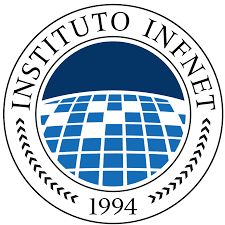

<h2>Pós-graduação MIT em Inteligência Artificial, Machine Learning & Deep Learning</h2>

**Bloco**: Clusterização de Dados
                                                                                
**Disciplina**: Validação de modelos de clusterização                                                                           


**Docente**: Luiz Fernando Frias                                                                                                                                

**Aluno**: Winicius Botelho Faquieri
                                                                                                                          

---

In [28]:
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib
# !pip install numpy
# !pip install sklearn
# !pip install yellowbrick

In [1]:
# Bibliotecas
import pandas as pd 
import seaborn as sns 
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

## Problema de Negócio

* O objetivo do presente trabalho é informar à equipe de marketing para qual grupo de clientes ela deve direcionar sua estratégia de captação. Por outras palavras, precisamos informar o grupo de clientes-alvo, aqueles que são mais fáceis de dialogar/convencer. Para tal, vamos utilizar dois algoritmos de aprendizado de máquina - KMeans Clustering e DBSCAN.


* Esse problema é conhecido na literatura como segmentação de clientes (customer segmentation). É o processo de dividir os clientes em grupos com base em características comuns para que as empresas possam fazer a comunicação com cada grupo de forma eficaz e adequada.


* Recomenda-se a leitura desse código em conjunto com o pdf, onde algumas questões são esmiuçadas e respondidas.

### Dataset

- ID do cliente, gênero, idade, renda anual e spending score


- Spending score é uma pontuação dada de acordo com o comportamento do cliente e os dados de compra.

In [2]:
df = pd.read_csv('data-raw/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.shape

(200, 5)

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [13]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [15]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [4]:
# Renomeando as colunas
df.rename(index=str, columns={'CustomerID': 'id', 'Gender': 'gender', 'Age': 'age', 'Annual Income (k$)': 'income',
                              'Spending Score (1-100)': 'spending_score'}, inplace=True)
df.head()

,id,gender,age,income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


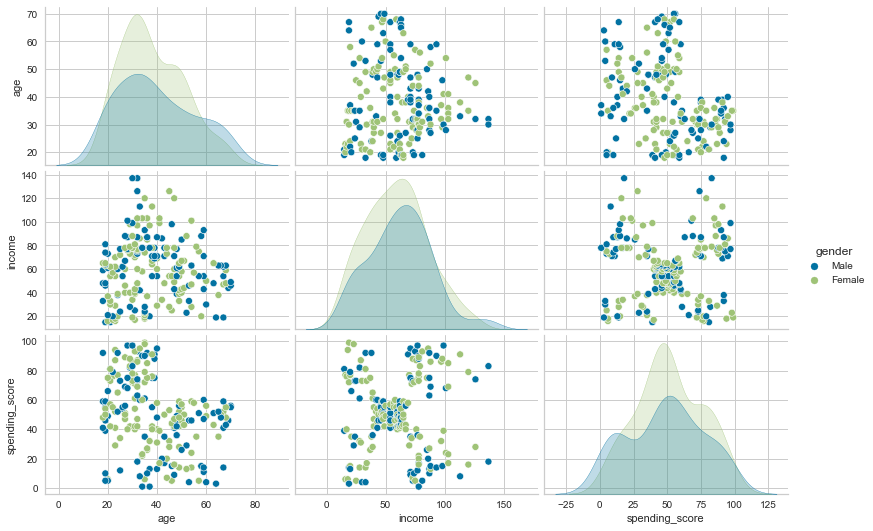

In [4]:
# a faixa dinâmica das variáveis que serão usadas nas tarefas de clusterização
X = df.drop(['id', 'gender'], axis=1)
sns.pairplot(df.drop('id', axis=1), hue='gender', aspect=1.5)
plt.show()

C:\Users\Winicius\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Winicius\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Winicius\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

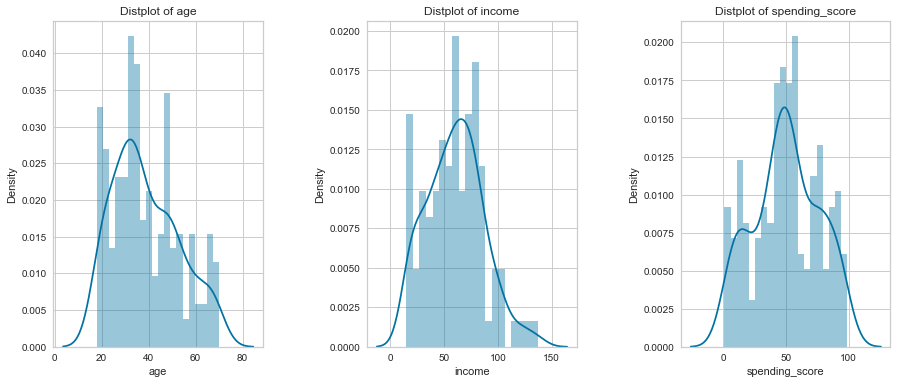

In [5]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['age' , 'income' , 'spending_score']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

In [36]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
income,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
spending_score,200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


<AxesSubplot:>

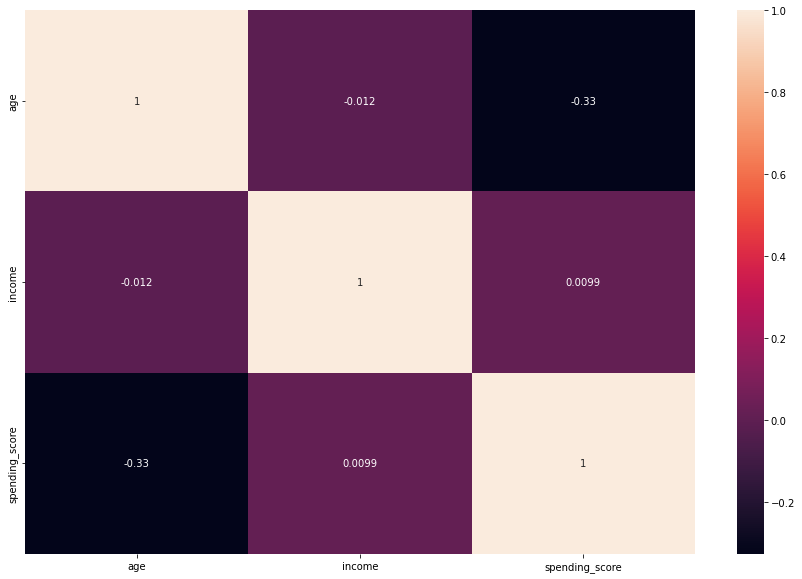

In [31]:
# Pearson
plt.figure(figsize=(15,10))
sns.heatmap(X.corr(method='pearson', min_periods=1),annot=True)

### Clusterização

#### Kmeans

- Dataset original

                count   mean        std   min    25%   50%   75%    max
age             200.0  38.85  13.969007  18.0  28.75  36.0  49.0   70.0
income          200.0  60.56  26.264721  15.0  41.50  61.5  78.0  137.0
spending_score  200.0  50.20  25.823522   1.0  34.75  50.0  73.0   99.0


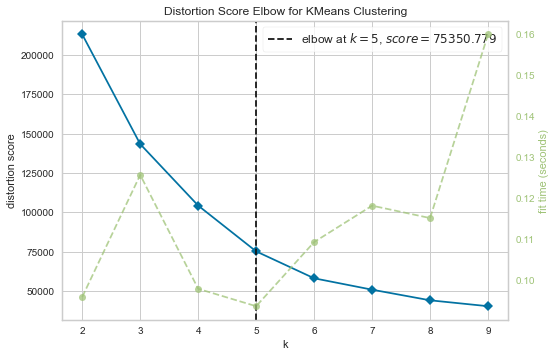

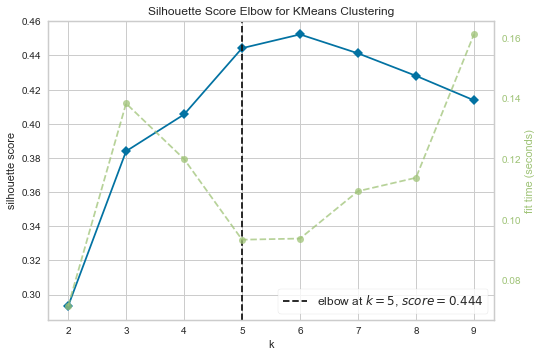

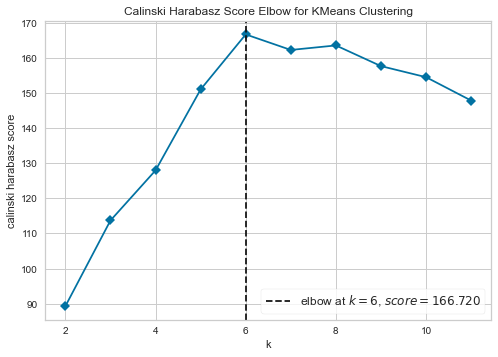

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [30]:
print(X.describe().T)

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X)
visualizer.show()
plt.show()

visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X)
visualizer.show()
plt.show()

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='calinski_harabasz', timings=False
)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

C:\Users\Winicius\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Winicius\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


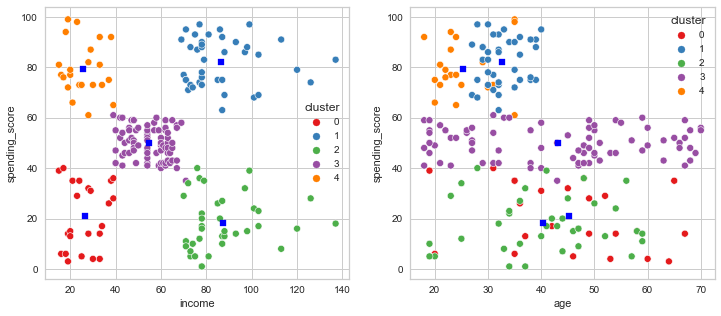

C:\Users\Winicius\AppData\Local\Temp\ipykernel_7080\2724141779.py:25: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)


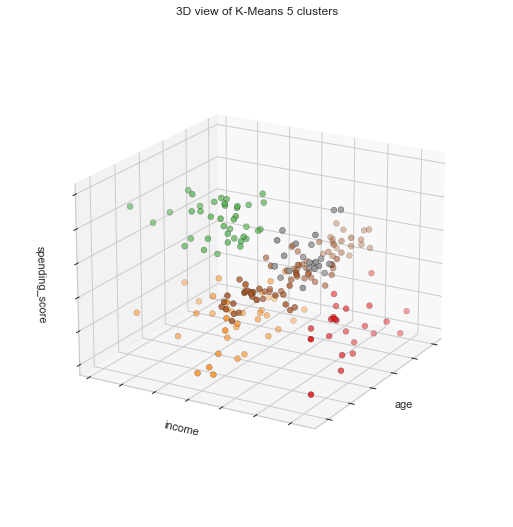

In [37]:
KM_clusters = KMeans(n_clusters=5, random_state=42, init='k-means++').fit(X) # initialise and fit K-Means model

KM_clustered = X.copy()
KM_clustered.loc[:,'cluster'] = KM_clusters.labels_ # append labels to points

fig1, (axes) = plt.subplots(1,2,figsize=(12,5))

scat_1 = sns.scatterplot('income', 'spending_score', data=KM_clustered,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('age', 'spending_score', data=KM_clustered,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_clusters.cluster_centers_[:,1],KM_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_clusters.cluster_centers_[:,0],KM_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

KM_clust_sizes = KM_clustered.groupby('cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes



fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM_clustered['age'],
           KM_clustered['income'],
           KM_clustered['spending_score'],
           c=KM_clustered['cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('age')
ax.set_ylabel('income')
ax.set_zlabel('spending_score')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

C:\Users\Winicius\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


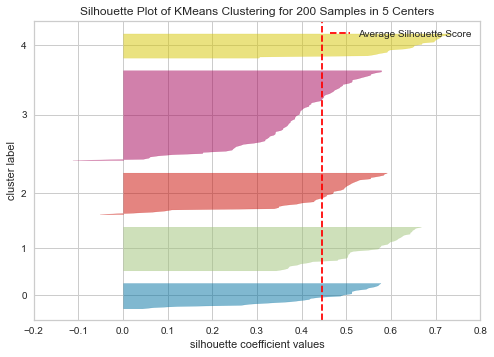

In [38]:
# Verificar a qualidade dos clusters
visualizer = SilhouetteVisualizer(KM_clusters, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()
plt.show()

- Para k=5, todos os clusters apresentaram pontuação acima da média do índice de silhueta, com espessura uniforme e sem grandes flutuações no tamanho.

In [7]:
# Cardinalidade - Quantidade de elementos por cluster:
KM_clust_sizes = KM_clustered.groupby('cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
cluster,
0,80
1,39
2,36
3,23
4,22


- Dataset normalizado (método robusto)

                count      mean       std       min       25%  50%       75%  \
age             200.0  0.140741  0.689828 -0.888889 -0.358025  0.0  0.641975   
income          200.0 -0.025753  0.719581 -1.273973 -0.547945  0.0  0.452055   
spending_score  200.0  0.005229  0.675125 -1.281046 -0.398693  0.0  0.601307   

                     max  
age             1.679012  
income          2.068493  
spending_score  1.281046  


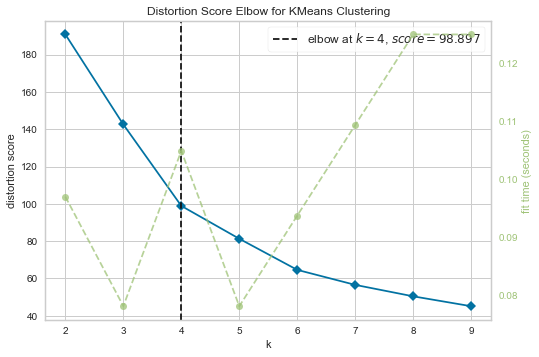

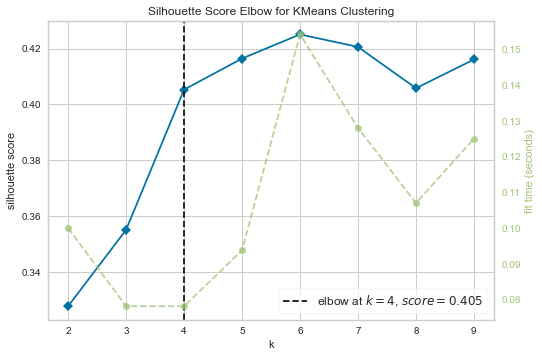

In [11]:
rs = RobustScaler() # Normalization

robust_df = X.copy()

# Normalization
robust_df['age'] = rs.fit_transform(robust_df[['age']])
robust_df['income'] = rs.fit_transform(robust_df[['income']])
robust_df['spending_score'] = rs.fit_transform(robust_df[['spending_score']])

print(robust_df.describe().T)

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(robust_df)
visualizer.show()
plt.show()

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(robust_df)
visualizer.show()
plt.show()

C:\Users\Winicius\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Winicius\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


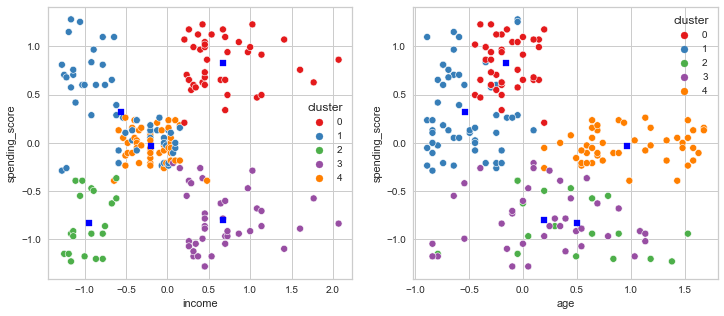

C:\Users\Winicius\AppData\Local\Temp\ipykernel_7080\3569888655.py:26: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)


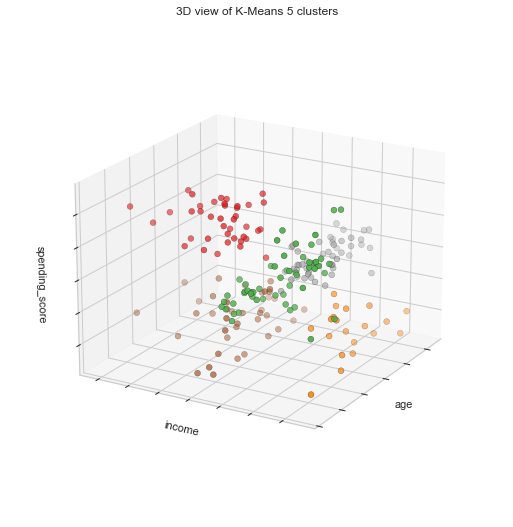

In [15]:
KM_clusters = KMeans(n_clusters=5, init='k-means++', random_state = 42).fit(robust_df) # initialise and fit K-Means model

KM_clustered = robust_df.copy()
KM_clustered.loc[:,'cluster'] = KM_clusters.labels_ # append labels to points

fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('income', 'spending_score', data=KM_clustered,
                hue='cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('age', 'spending_score', data=KM_clustered,
                hue='cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_clusters.cluster_centers_[:,1],KM_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_clusters.cluster_centers_[:,0],KM_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

KM_clust_sizes = KM_clustered.groupby('cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM_clustered['age'],
           KM_clustered['income'],
           KM_clustered['spending_score'],
           c=KM_clustered['cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('age')
ax.set_ylabel('income')
ax.set_zlabel('spending_score')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()



- Cardinalidade - Quantidade de elementos por cluster:

In [56]:
KM_clust_sizes = KM_clustered.groupby('cluster').size().to_frame()
KM_clust_sizes.columns = ["Cardinalidade"]
KM_clust_sizes

,Cardinalidade
cluster,
0,38
1,40
2,57
3,65


C:\Users\Winicius\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


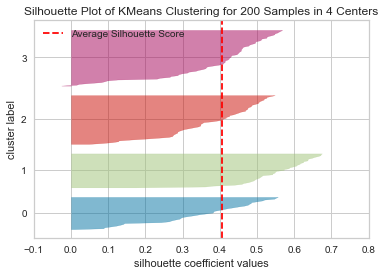

In [23]:
visualizer = SilhouetteVisualizer(KM_clusters, colors='yellowbrick')
visualizer.fit(robust_df)
visualizer.show()
plt.show()

#### DBSCAN

In [20]:
eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(robust_df, DBS_clustering.labels_))

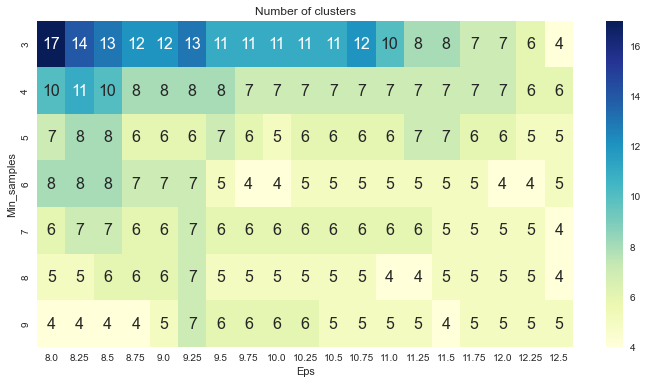

In [21]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

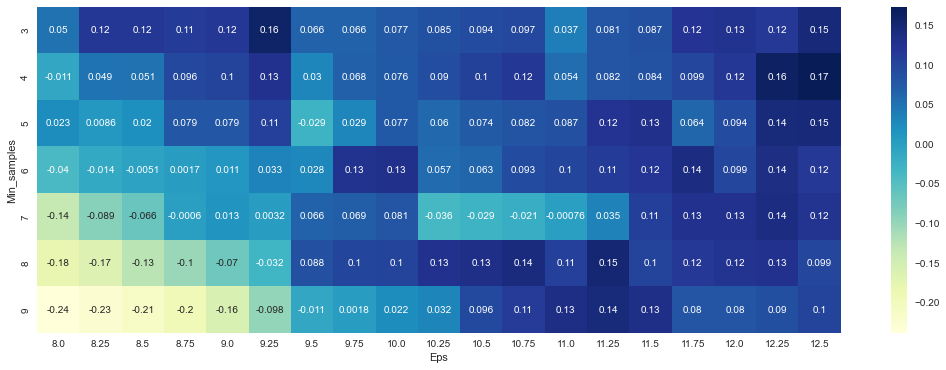

In [22]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

In [25]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X)

DBSCAN_clustered = robust_df.copy()
DBSCAN_clustered.loc[:,'cluster'] = DBS_clustering.labels_ # append labels to points

In [26]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


- O DBSCAN criou 5 clusters mais o cluster de outliers (-1). Os tamanhos dos clusters variam de  0-4 - alguns têm apenas 4 ou 8 observações. Existem 18 valores classificados como outliers.

C:\Users\Winicius\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Winicius\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


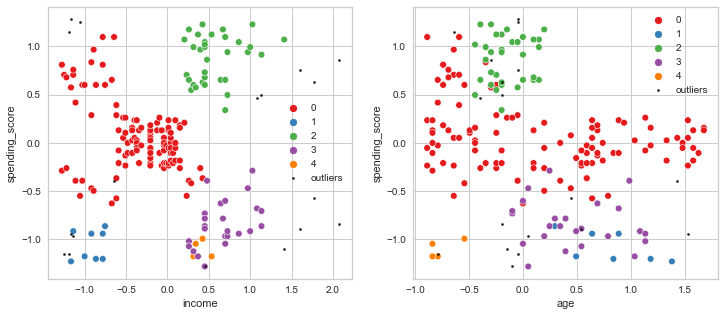

In [27]:
outliers = DBSCAN_clustered[DBSCAN_clustered['cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('income', 'spending_score',
                data=DBSCAN_clustered[DBSCAN_clustered['cluster']!=-1],
                hue='cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('age', 'spending_score',
                data=DBSCAN_clustered[DBSCAN_clustered['cluster']!=-1],
                hue='cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['income'], outliers['spending_score'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['age'], outliers['spending_score'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

In [83]:
clusters = pd.concat([KM_clust_sizes, DBSCAN_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size
cluster,,
0,23.0,112
1,39.0,8
2,37.0,34
3,79.0,24
4,22.0,4
-1,NaN,18
